In [1]:
# import os
# import sys

import numpy as np
import random as rand
import matplotlib.pyplot as plt
import scipy
import math
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Make the plots a bit bigger to see
# NOTE: Must be done in a separate cell
plt.rcParams['figure.dpi'] = 100

In [3]:
#### parameters for simulations ####
parameter = {
    'mx': 20,
    'my': 20,
    'nwarm':200000,
    'nskip':4096,
    'Tc':1.0,
    'coef':0.1,
    'dphi':0.2,
    'gamma':0.05,
    'r0':2.0,
    'Rload':0.5
}

# file= open("blah.txt","w+")

In [4]:
class Ginz_Landau_FE:
    def __init__(self,parameter,E,Tb,phi,seed):
        self.parameter = parameter
        for iparam,param in parameter.items():
            setattr(self, iparam, parameter[iparam])
        self.E = E                                 ## Electric Field added as an input
        self.Tb = Tb                               ## Bath Temperature
        self.phi = phi                             ## Order parameter lattice
        self.ms = np.ones((self.mx,self.my))       ## Mean Field order parameter (to determine Teff)
        self.v0 = np.ones((self.mx,self.my))  
        self.phi_new = np.zeros((self.mx,self.my)) ## Copy of order parameter (may be commented out)
#         self.v0 = disorder*np.random.rand((mx,my)) 
        self.Teff = self.Tb*np.ones((self.mx,self.my)) ## Effective Temperature of the lattice
        self.dx = 1.0      ## Step along X-axis
        self.dy = 1.0      ## Step along Y-axis
        self.Lx = self.dx*(float(self.mx))  ## Length of sample
        self.Ly = self.dy*(float(self.my))  ## Breadth of sample
        self.volt = self.E*self.Ly          ## Volatge bais 
        self.eq_flag = True     ## Flag for equilibriation True --> Warming , False --> Measurement
        self.seed = seed    ## Random Seed
    
    ## Compute Gradient of any 2x2 array (periodic along X, but not Y)
    def gradient(self,f):
        du = np.zeros((self.mx,self.my))
#         for i in range(self.mx):
#             for j in range(self.my):
#                 dg[i,j] = self.grad(f[i,j],i,j)
        du[1:-1,0:] += ( (f[2:,0:] - f[1:-1,0:]) /self.dx)**2 + ((f[0:-2,0:] - f[1:-1,0:])/self.dx)**2 
        du[:,1:-1] += ((f[:,2:] - f[:,1:-1])/self.dy)**2 + ((f[:,0:-2] - f[:,1:-1])/self.dy)**2 
        du[0,:] += ((f[1,:] - f[0,:])/self.dx)**2 + ((f[-1,:] - f[0,:])/self.dx)**2
        du[-1,:] += ((f[0,0:] - f[-1,0:])/self.dx)**2 + ((f[-2,0:] - f[-1,0:])/self.dx)**2
        du[:,0] += ((f[:,1] - f[:,0])/self.dy)**2
        du[:,-1] += ((f[:,-2] - f[:,-1])/self.dy)**2
        return du

    ## Local Gradient
    def grad_phi(self,phi_loc,i,j):
        i1 = (i-1+self.mx)%self.mx
        i2 = (i+1)%self.mx
        dg = ((self.phi[i2,j] - phi_loc)/self.dx)**2 + ((self.phi[i1,j]-phi_loc)/self.dx)**2 
        if j > 0 :
            dg += ((self.phi[i,j-1]-phi_loc)/self.dy)**2
        if j < (self.my-1):
            dg += ((self.phi[i,j+1]-phi_loc)/self.dy)**2    
        return dg

    ## Compute Free Energy as an array
    def free_energy(self):
        term1 = 0.5*((self.Teff/self.Tc) - 1.0)*self.phi**2 
        term2 = 0.5*self.r0*self.gradient(self.phi)
        term3 = 0.25*self.phi**4
        fe = term1 + term2 + term3
        return fe*self.dx*self.dy
    
    ## Local Free Energy computation (Not used but may be used)
    def local_fe(self, phi_loc, Teff_loc, i, j):
        self.phi_new = self.phi_new + self.phi
        self.phi_new[i,j] = phi_loc
        del_phi = self.gradient(self.phi_new)
        fij = 0.5*((Teff_loc/self.Tc) - 1.0)*phi_loc**2 + 0.25*phi_loc**4 + 0.5*self.r0*self.grad_phi(phi_loc,i,j) 
        self.phi_new = np.zeros((self.mx,self.my))
        return fij*self.dx*self.dy
    
    ## Calculating Energy difference between two points on the lattice
    def dfree(self,phi1,Teff1,i,j):
        df = -0.5*(phi1**2-self.phi[i,j]**2) + 0.5*Teff1/self.Tc*phi1**2 - 0.5*self.Teff[i,j]/self.Tc*self.phi[i,j]**2
        df += 0.25*(phi1**4-self.phi[i,j]**4)
        df += 0.5*self.r0*(self.grad_phi(phi1,i,j) - self.grad_phi(self.phi[i,j],i,j))
        return df*self.dx*self.dy

    ## Monte Carlo Loop
    def heatbath_loop(self,f):
        ## set Random Seed
        self.seed += 1
        np.random.seed(self.seed)        
        ncount = 0
        iflip = 0
        icount = np.zeros((self.mx,self.my),dtype=int)
        self.ms = self.ms*0.0
        ## set flag
        if(self.eq_flag):
            nsteps = self.nwarm
        else:
            nsteps = self.nskip
            
        for ii in range(0,nsteps):
            i = np.random.randint(0,self.mx)
            j = np.random.randint(0,self.my)
            ## original order parameter
            phi0 = self.phi[i,j]
            f0 = self.local_fe(self.phi[i,j],self.Teff[i,j],i,j)
            ## new order parameter
#             phi1 = self.phi[i,j] + 2.0*self.dphi*(np.random.rand() - 0.5) 
            phi1 = self.phi[i,j] + np.random.uniform(-self.dphi,self.dphi)
            Teff1 = self.Teff[i,j]
            f1 = self.local_fe(phi1,Teff1,i,j)
            ## computing the differnce in energy
            df = self.dfree(phi1,Teff1,i,j)
            icount[i,j] += 1
            ncount += 1
            ## MC MC step
            if np.random.rand() < np.exp(-df/self.Tb):
                self.phi[i,j] = phi1     
                self.Teff[i,j] = Teff1
                f += df
                iflip += 1
                                
            self.ms[i,j] += self.phi[i,j]
            
        self.ms = np.where(icount == 0, self.phi , self.ms/icount)        
        rate = float(iflip)/float(ncount)
        
        return self.phi, self.Teff, self.ms, f

    ## Compute Effective Temperature    
    def setTeff(self):
        tbath = self.Tb*np.ones((self.mx,self.my))
        gam = self.gamma*np.ones((self.mx,self.my))
        efield = self.coef*self.E*np.ones((self.mx,self.my))
        return np.sqrt(tbath**2 + efield**2/(gam**2 + self.ms**2) )
    
    ## Compute Averages
    def averages(self,f):
        ave_phi = np.mean(self.phi)
        std_phi = np.std(self.phi)
        ave_phi2 = np.mean(self.phi**2)
        std_phi2 = np.std(self.phi**2)
        ave_fe = f/(self.mx*self.my)
        std_fe = np.sqrt((f**2 - ave_fe**2)/(self.mx*self.my))
        ave_teff = np.mean(self.Teff)
        return std_fe, std_phi, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2
    
    ## Function initiating the Warming of the lattice
    def warming(self):
        self.Teff = self.setTeff()
        f = np.sum(self.free_energy())
        self.phi, self.Teff, self.ms, f = self.heatbath_loop(f) 
        return self, f
    
    ## Function intiating the production runs and gives out the measurements
    def meas(self,f):
        self.eq_flag = False
        self.Teff = self.setTeff()
        f = np.sum(self.free_energy())
        self.phi, self.Teff, self.ms, f = self.heatbath_loop(f)
        std_fe, std_phi, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2 = self.averages(f)
        ft = self.free_energy()
        return std_fe, std_phi, ave_phi, ave_fe, ave_teff, ave_phi2, std_phi2, ft.flatten(), self.phi
        
    
           

Tbvals : [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11 1.12
 1.13 1.14 1.15 1.16 1.17 1.18 1.19]
[ 0.01        0.99335434  0.03549516 -0.2345512   4.69100932  0.98802462
  0.07048195  0.01419063]
[ 0.02        0.98496428  0.05071758 -0.22163787  4.43274349  0.97275002
  0.09971915  0.02242671]
[ 0.03        0.97803208  0.06275025 -0.20763705  4.152728    0.96050587
  0.1227878   0.03169762]
[ 0.04        0.97108448  0.07348945 -0.19427598  3.88550743  0.94843626
  0.14253718  0.0

[ 0.8        -0.02424688  0.41875573  0.73968468 14.79364741  0.17638385
  0.23283002  0.80360196]
[ 0.81       -0.0473662   0.45454914  0.73465465 14.69304706  0.20937602
  0.26244308  0.81337664]
[ 0.82       -0.04004286  0.38038544  0.73722504 14.74445467  0.14658964
  0.2049009   0.82405648]
[ 0.83       -0.06667363  0.41206702  0.76335837 15.26711971  0.1745662
  0.23102762  0.83369724]
[ 0.84       -0.0406053   0.40502088  0.76081182 15.2161888   0.16596676
  0.22312669  0.84382526]
[8.50000000e-01 1.34765665e-02 4.40385603e-01 8.30974071e-01
 1.66194295e+01 1.94371566e-01 2.64754449e-01 8.53400878e-01]
[ 0.86       -0.10985182  0.43761548  0.80251927 16.05033528  0.20390247
  0.26772059  0.8633934 ]
[ 0.87        0.12442453  0.3909736   0.83381049 16.67615773  0.16843873
  0.22447195  0.87366484]
[8.80000000e-01 1.57444065e-02 4.21194185e-01 8.37744661e-01
 1.67548409e+01 1.78119588e-01 2.39820542e-01 8.83453202e-01]
[ 0.89        0.06880388  0.41881375  0.86485568 17.29705951  

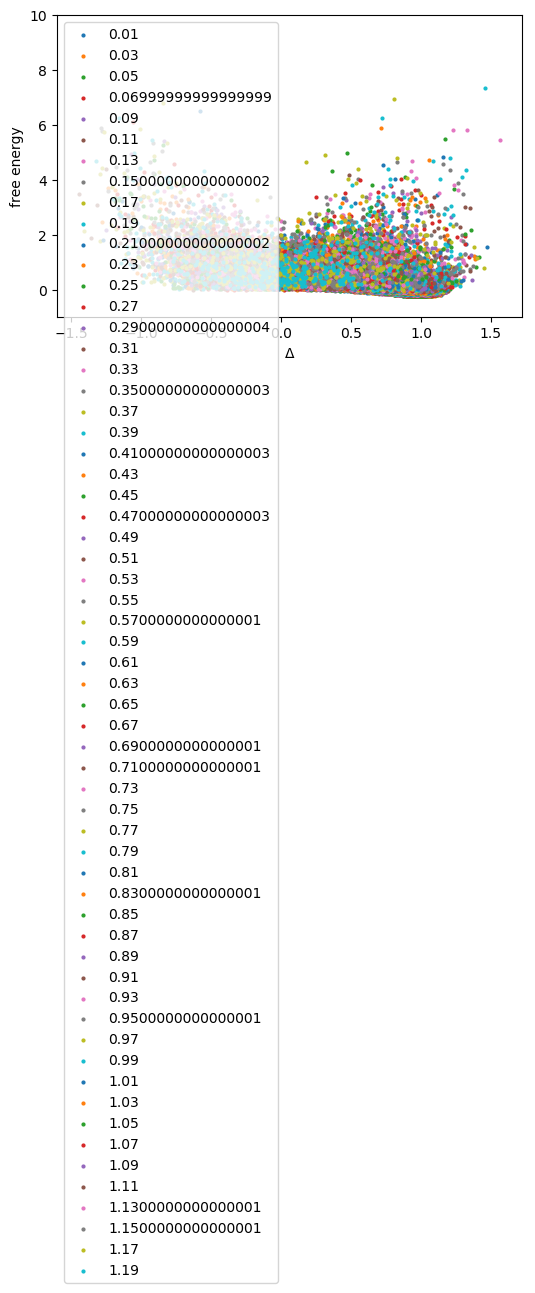

In [5]:
nmeas = 8
ndata = 40 
Mx = parameter["mx"]
My = parameter["my"]
# Tbvals = np.linspace(0.001,1.2,ndata)
# Tbvals = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
Tbvals = np.arange(0.01,1.2,0.01)
# Tbvals = np.append(Tbvals,Tbvals[::-1])
ndata = np.size(Tbvals)
print("Tbvals :",Tbvals)
E = 0.1
Data_Set = np.zeros((ndata,8))
k = 0
phit = np.ones((Mx,My))
seed = 32
for Tb in Tbvals:  
    glt = Ginz_Landau_FE(parameter,E,Tb,phit,seed)
    fm = glt.warming()
    Data_Set[k,0] = Tb
    for i in range(0,nmeas):
        f2 , delta2 , delta, f , teff , ohm, ohm2, ft, phit = glt.meas(fm)
        Data_Set[k,1:8] += [delta , delta2 , f, f2 , ohm, ohm2, teff]
    
    if k%2 == 0:
        phi_val = phit.flatten()
        plt.scatter(phi_val,ft,s = 4.0,label=(Tb))
        
    Data_Set[k,1:8] = Data_Set[k,1:8]/nmeas
    print(Data_Set[k,:])    
    k += 1
    seed += 1

plt.legend()
plt.xlabel(r'$\Delta$')
plt.ylabel("free energy")
plt.ylim(-1.0,10.0)
plt.show()

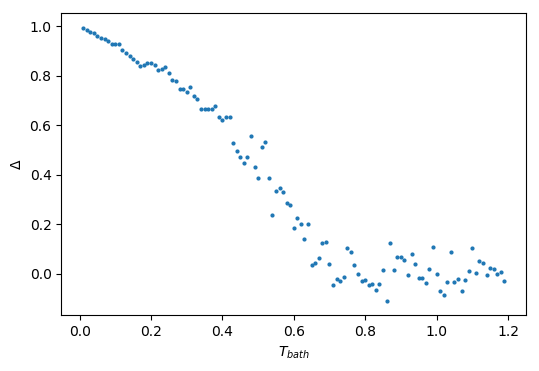

In [6]:
plt.scatter(Data_Set[:,0],Data_Set[:,1], s = 4.0)
# plt.plot(Data_Set[:,0],Data_Set[:,1])
plt.xlabel(r'$T_{bath}$')
plt.ylabel(r'$\Delta$')           
plt.show()

In [7]:
#     def dfree(self,phi1,Teff1,i,j):
#         phi_new = self.phi
#         phi_new[i,j] = phi1
#         del_phi1 = self.gradient(phi_new)
#         del_phi0 = self.gradient(self.phi)
        
#         df = -0.5*(phi1**2-self.phi[i,j]**2) + 0.5*Teff1/self.Tc*phi1**2 - 0.5*self.Teff[i,j]/self.Tc*self.phi[i,j]**2
#         df += 0.25*(phi1**4-self.phi[i,j]**4)
#         df += 0.5*self.r0*(del_phi1[i,j] - del_phi0[i,j])
#         return df*self.dx*self.dy
